In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
ejlok1_toronto_emotional_speech_set_tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
ejlok1_cremad_path = kagglehub.dataset_download('ejlok1/cremad')
ejlok1_surrey_audiovisual_expressed_emotion_savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


Data source import complete.


#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

/tmp/ipython-input-8-800787859.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


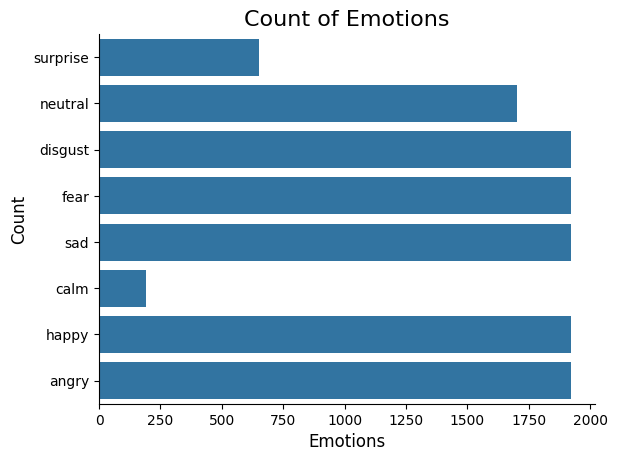

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

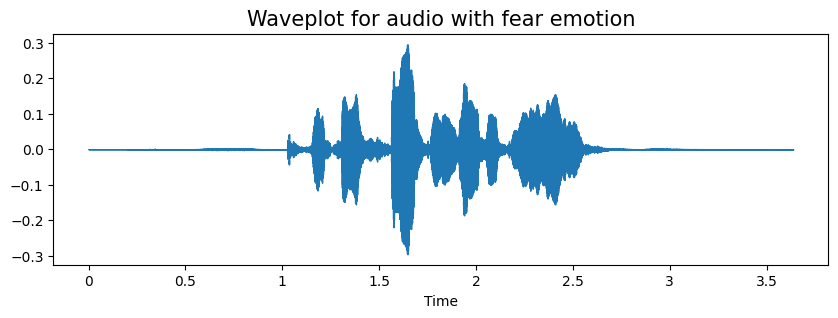

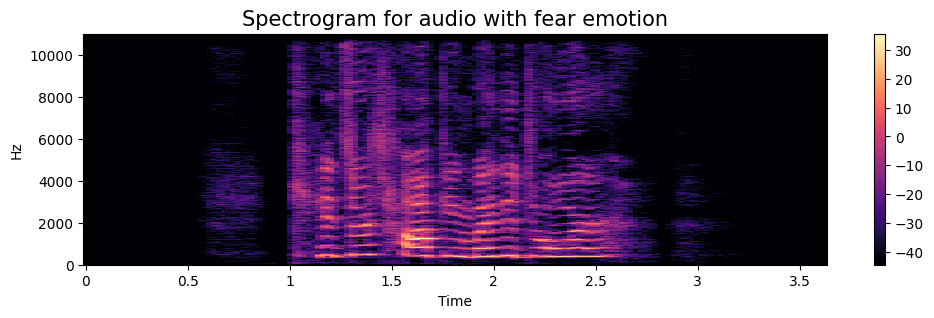

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

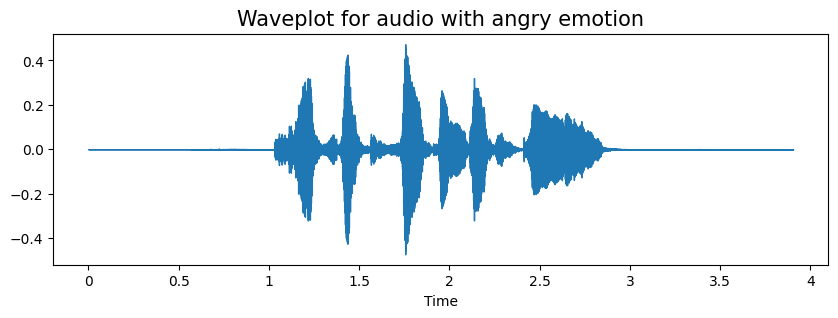

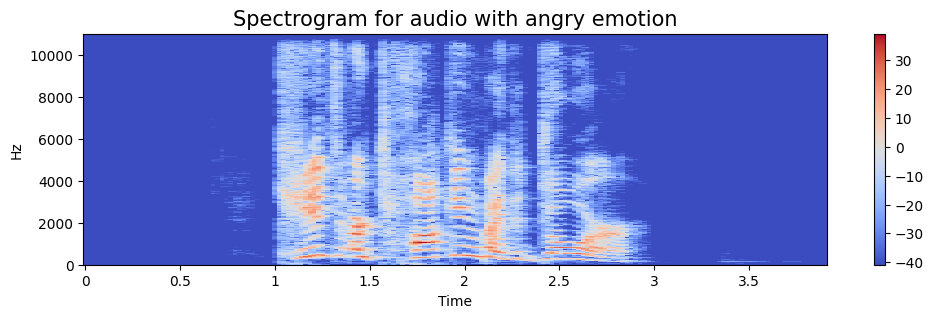

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

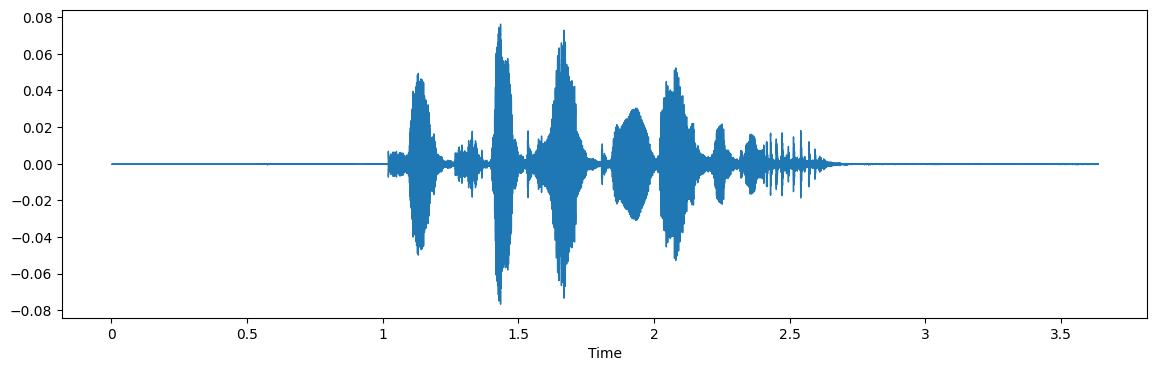

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

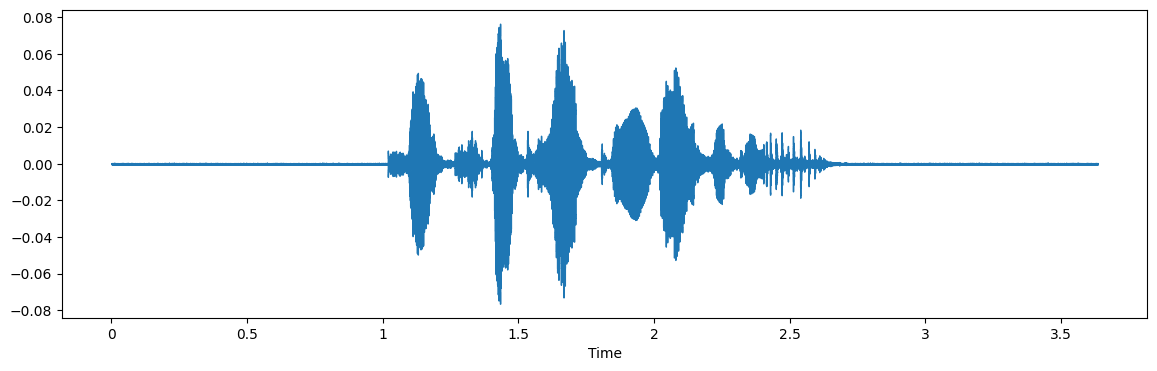

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.294067,0.693566,0.703649,0.683733,0.671090,0.700776,0.694066,0.692721,0.671148,0.692280,...,0.000351,0.000345,0.000247,0.000250,0.000409,0.000477,0.000395,0.000286,1.506113e-04,surprise
2,0.185670,0.701611,0.669992,0.646513,0.569490,0.522187,0.620173,0.694166,0.706138,0.679080,...,0.000047,0.000049,0.000054,0.000048,0.000024,0.000053,0.000074,0.000031,2.444070e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral
4,0.339274,0.701821,0.715146,0.751413,0.779303,0.764029,0.691156,0.700015,0.741754,0.742205,...,0.000405,0.000388,0.000395,0.000386,0.000374,0.000371,0.000369,0.000384,3.785971e-04,neutral


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 185s 425ms/step - accuracy: 0.2764 - loss: 1.8064 - val_accuracy: 0.3984 - val_loss: 1.4881 - learning_rate: 0.0010
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 206s 436ms/step - accuracy: 0.4022 - loss: 1.4911 - val_accuracy: 0.4723 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 202s 437ms/step - accuracy: 0.4431 - loss: 1.3925 - val_accuracy: 0.4792 - val_loss: 1.3196 - learning_rate: 0.0010
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 193s 416ms/step - accuracy: 0.4665 - loss: 1.3322 - val_accuracy: 0.5050 - val_loss: 1.2353 - learning_rate: 0.0010
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 176s 411ms/step - accuracy: 0.4835 - loss: 1.2866 - val_accuracy: 0.5135 - val_loss: 1.2293 - learning_rate: 0.0010
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 208s 426ms/step - accuracy: 0.4902 - loss: 1.2560 - val_accuracy: 0.5278 - val_loss: 1.1974 - learning_rate: 0.0010
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 196s 412ms/step - accura

286/286 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.6284 - loss: 1.0604
Accuracy of our model on test data :  62.71650791168213 %


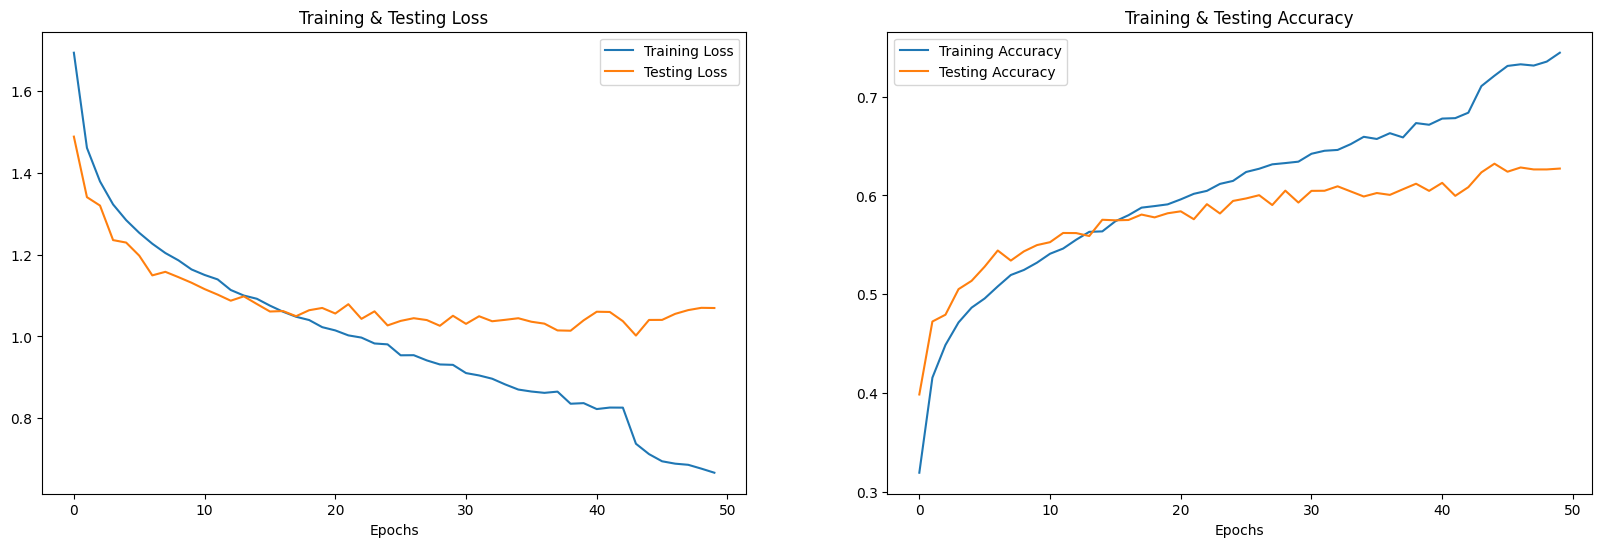

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,disgust
1,neutral,neutral
2,fear,fear
3,happy,angry
4,fear,fear
5,sad,disgust
6,angry,angry
7,disgust,disgust
8,neutral,disgust
9,neutral,neutral


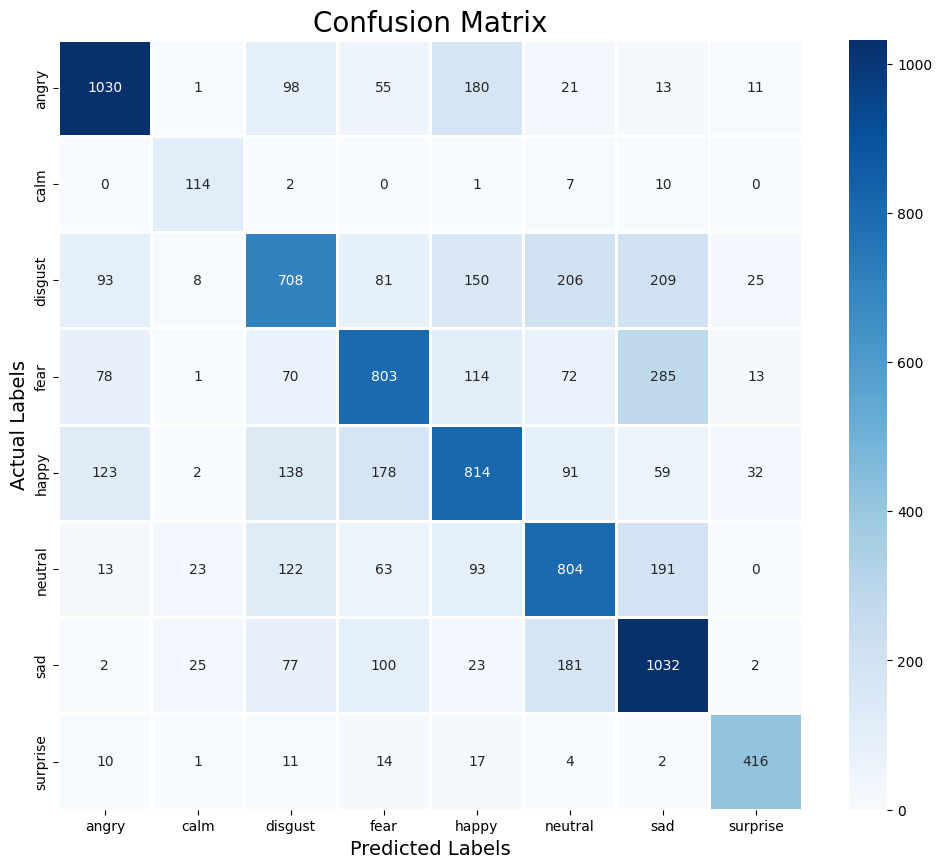

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.73      0.75      1409
        calm       0.65      0.85      0.74       134
     disgust       0.58      0.48      0.52      1480
        fear       0.62      0.56      0.59      1436
       happy       0.58      0.57      0.58      1437
     neutral       0.58      0.61      0.60      1309
         sad       0.57      0.72      0.64      1442
    surprise       0.83      0.88      0.85       475

    accuracy                           0.63      9122
   macro avg       0.65      0.67      0.66      9122
weighted avg       0.63      0.63      0.63      9122



# Task
Convert the Keras model to a quantized TensorFlow Lite model and save it.

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp0tfleya_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 162, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137577029648656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029651344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029649424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029653264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137579030656208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029662480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027163088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027161936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027163472: Te

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

Saved artifact at '/tmp/tmp7z_8ihgr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 162, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137577029648656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029651344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029664400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029649424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029653264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137579030656208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029662864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577029662480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027163088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027161936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137577027163472: Te

In [ ]:
quantized_model_file = 'quantized_emotion_recognition_model.tflite'
with open(quantized_model_file, 'wb') as f:
    f.write(quantized_tflite_model)